Things to explore/do here:
1. make some slice plots of the function that we are interpolating. how noisy is it currently?
2. jax interpolation. without jax interpolation, everything is for naught because it'll be slow.
3. real code!! not just a janky example.
4. unstructured interpolation grids that are higher density in regions where that's necessary. We could start by dividing the domain into just a few hyper-triangles and then divide only those triangles where the edge midpts/center are substantially different from the existing vertices. This might be necessary fairly early because it seems like the function we're interpolating can have dramatic changes in value with respect to the input space.

In [1]:
import outlaw.nb_util as nb_util
nb_util.setup_nb()

In [2]:
import scipy.interpolate
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import lewis

/Users/tbent/.mambaforge/envs/confirm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
params = {
    "n_arms" : 4,
    "n_stage_1" : 10,
    "n_stage_2" : 10,
    "n_interims" : 3,
    "n_add_per_interim" : 4,
    "futility_threshold" : 0.1,
    "pps_threshold_lower" : 0.1,
    "pps_threshold_upper" : 0.9,
    "posterior_difference_threshold" : 0.05,
    "rejection_threshold" : 0.05,
    "n_pr_sims" : 100,
    "n_sig2_sim" : 20,
    "batch_size" : 2**17,
}

LL = lewis.Lewis45(**params)

In [4]:
(
    LL.n_configs_max_mask,
    LL.n_configs_ph2,
    LL.n_configs_ph3,
    LL.hashes_ph2,
    LL.hashes_ph3,
    LL.offsets_ph2,
    LL.offsets_ph3,
) = LL.n_configs_setting__()

In [5]:
ns = LL.n_configs_ph3[0]
all_data = LL.table_data__(
    ns, jnp.meshgrid(*(jnp.arange(0, n + 1) for n in ns), indexing="ij")
)
data = all_data[10000]

In [6]:
y = data[:, 0]
n = data[:, 1]
print(y, n)

[ 0 18 20 18] [20 20 22 22]


In [7]:
hashes = LL.hashes_ph3
offsets = LL.offsets_ph3
LL.posterior_difference_table[LL.hash__(y, n, LL.hashes_ph3, LL.offsets_ph3)]

DeviceArray([0.00621347, 0.00417244, 0.0788037 ], dtype=float64)

In [8]:
def get_index(y, n):
    return y[-1] + jnp.sum(jnp.flip(y[:-1]) * jnp.cumprod(n + 1)[:-1])
table_n0 = LL.posterior_difference_table[:LL.offsets_ph3[1]]
table_n0[get_index(y, n)]

DeviceArray([0.00621347, 0.00417244, 0.0788037 ], dtype=float64)

In [9]:
yi_range = [jnp.arange(0, ni + 1, 2) for ni in n]
yi_grid = jnp.meshgrid(*yi_range, indexing="ij")
y_grid_1d = jnp.stack(yi_grid, axis=-1).reshape((-1, 4))
y_grid_1d.shape

(17424, 4)

In [10]:
get_idx_vmap = jax.vmap(get_index, in_axes=(0, None))
table_idx = get_idx_vmap(y_grid_1d, n)
subset_table_n0 = table_n0[table_idx].reshape((*yi_grid[0].shape, 3))
subset_table_n0.shape

(11, 11, 12, 12, 3)

Does the interpolation result match the mean of the corners of the zone that the lookup point is in?

Yes! This is exactly as we'd expect from a linear interpolation.

In [11]:
y_test = np.array([[14, 14, 11, 11]])
print(f"n={n}, table y={table_n0[get_idx_vmap(y_test, n)]}")
print(
    f"corners="
    f"\n{table_n0[get_idx_vmap(np.array([[14, 14, 10, 10]]), n)]}"
    f"\n{table_n0[get_idx_vmap(np.array([[14, 14, 12, 10]]), n)]}"
    f"\n{table_n0[get_idx_vmap(np.array([[14, 14, 12, 12]]), n)]}"
    f"\n{table_n0[get_idx_vmap(np.array([[14, 14, 10, 12]]), n)]}"
)
interp_vals = np.array(
    [
        scipy.interpolate.interpn(yi_range, subset_table_n0[..., d], y_test)[0]
        for d in range(3)
    ]
)
print(f"interp={interp_vals}")

print('what would we expect from the mean??', np.mean([
    table_n0[get_idx_vmap(np.array([[14, 14, 10, 10]]), n)],
    table_n0[get_idx_vmap(np.array([[14, 14, 12, 10]]), n)],
    table_n0[get_idx_vmap(np.array([[14, 14, 12, 12]]), n)],
    table_n0[get_idx_vmap(np.array([[14, 14, 10, 12]]), n)],
], axis=0))

n=[20 20 22 22], table y=[[0.96856094 0.77199198 0.01656539]]
corners=
[[0.96988088 0.76734262 0.99532791]]
[[0.94371537 0.67245688 0.16150592]]
[[0.96115625 0.67331749 0.03090288]]
[[0.95858466 0.75185198 0.9987251 ]]
interp=[0.95833429 0.71624224 0.54661545]
what would we expect from the mean?? [[0.95833429 0.71624224 0.54661545]]


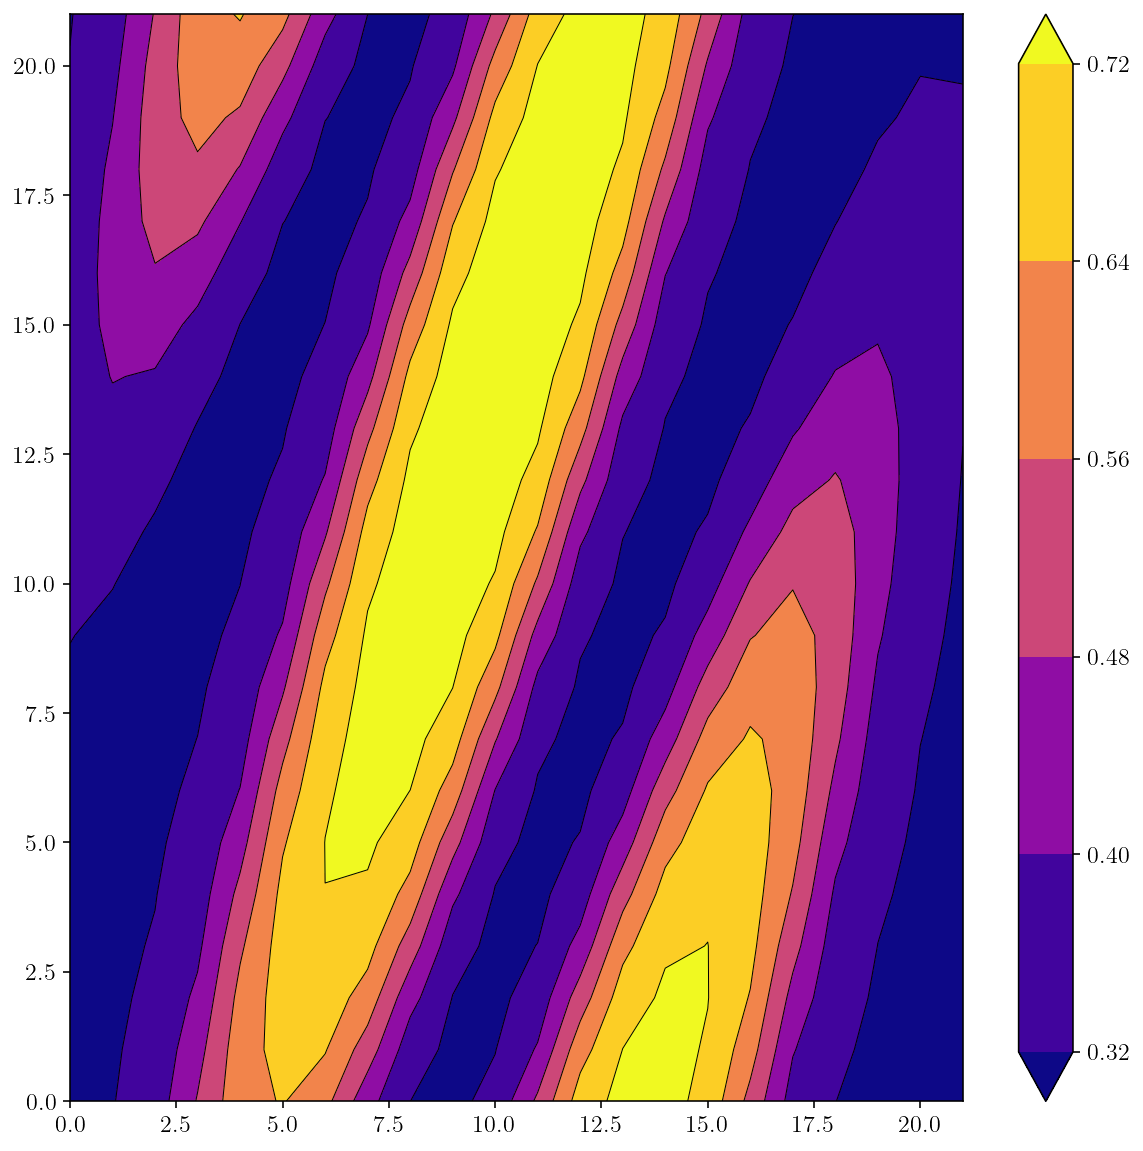

In [14]:
y0 = 10
y1 = 10
y2 = np.arange(0, ns[2])
y3 = np.arange(0, ns[3])
yplot_grid = jnp.meshgrid(y2, y3, indexing="ij")
yplot_grid1d = np.stack(yplot_grid, axis=-1).reshape((-1, 2))
nplot = yplot_grid1d.shape[0]
yplot_grid1d = np.concatenate((np.full((nplot, 1), y0), np.full((nplot, 1), y1), yplot_grid1d), axis=-1)
Aplot = table_n0[get_idx_vmap(yplot_grid1d, n)][:,0].reshape(yplot_grid[0].shape)

plt.figure(figsize=(10, 10))
levels=None
nb_util.contourf_tbt(yplot_grid[0], yplot_grid[1], Aplot, levels=levels)
plt.show()

In [14]:
interp_pts = yi_range
grid = tuple([np.asarray(p) for p in interp_pts])
interp_vals = subset_table_n0[..., 0]
lookup_pts = y_test

In [15]:
xi = y_test[0]
indices = []
# compute distance to lower edge in unity units
norm_distances = []
# iterate through dimensions
for x, g in zip(xi, grid):
    i = np.searchsorted(g, x) - 1
    i = jnp.where(i > 0, i, 0)
    i = jnp.where(i > g.size - 2, g.size - 2, i)
    indices.append(i)

    # compute norm_distances, incl length-1 grids,
    # where `grid[i+1] == grid[i]`
    denom = g[i + 1] - g[i]
    with np.errstate(divide='ignore', invalid='ignore'):
        norm_dist = np.where(denom != 0, (x - g[i]) / denom, 0)
    norm_distances.append(norm_dist)

In [184]:
indices

[DeviceArray(5, dtype=int64),
 DeviceArray(5, dtype=int64),
 DeviceArray(5, dtype=int64),
 DeviceArray(5, dtype=int64)]

In [176]:
jnp.searchsorted(grid[0], xi[0])

DeviceArray([6, 6, 6, 6], dtype=int32)

In [170]:
norm_distances

[array([1. , 1. , 0.5, 0.5])]

In [ ]:
def _find_indices(self, xi):
    # find relevant edges between which xi are situated
    indices = []
    # compute distance to lower edge in unity units
    norm_distances = []
    # iterate through dimensions
    for x, grid in zip(xi, self.grid):
        i = np.searchsorted(grid, x) - 1
        i[i < 0] = 0
        i[i > grid.size - 2] = grid.size - 2
        indices.append(i)

        # compute norm_distances, incl length-1 grids,
        # where `grid[i+1] == grid[i]`
        denom = grid[i + 1] - grid[i]
        with np.errstate(divide='ignore', invalid='ignore'):
            norm_dist = np.where(denom != 0, (x - grid[i]) / denom, 0)
        norm_distances.append(norm_dist)

    return indices, norm_distances

In [ ]:
def _evaluate_linear(self, indices, norm_distances):
    # slice for broadcasting over trailing dimensions in self.values
    vslice = (slice(None),) + (None,)*(self.values.ndim - len(indices))

    # Compute shifting up front before zipping everything together
    shift_norm_distances = [1 - yi for yi in norm_distances]
    shift_indices = [i + 1 for i in indices]

    # The formula for linear interpolation in 2d takes the form:
    # values = self.values[(i0, i1)] * (1 - y0) * (1 - y1) + \
    #          self.values[(i0, i1 + 1)] * (1 - y0) * y1 + \
    #          self.values[(i0 + 1, i1)] * y0 * (1 - y1) + \
    #          self.values[(i0 + 1, i1 + 1)] * y0 * y1
    # We pair i with 1 - yi (zipped1) and i + 1 with yi (zipped2)
    zipped1 = zip(indices, shift_norm_distances)
    zipped2 = zip(shift_indices, norm_distances)

    # Take all products of zipped1 and zipped2 and iterate over them
    # to get the terms in the above formula. This corresponds to iterating
    # over the vertices of a hypercube.
    hypercube = itertools.product(*zip(zipped1, zipped2))
    values = 0.
    for h in hypercube:
        edge_indices, weights = zip(*h)
        weight = 1.
        for w in weights:
            weight *= w
        values += np.asarray(self.values[edge_indices]) * weight[vslice]
    return values